# Canonical Transformations

celmech provides functionality for doing canonical transformations, and convenience classes for the types of transformations that come up most often. We start by creating a REBOUND simulation of a 2 planet system near the 3:2 MMR, and create a Hamiltonian that includes various eccentricity and inclination 3:2 terms as well as secular terms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound as rb
from celmech import PoincareHamiltonian,Poincare
from celmech.canonical_transformations import CanonicalTransformation

import sympy
from sympy import init_printing
init_printing()

In [2]:
sim = rb.Simulation()
sim.add(m=1)
sim.add(m=3e-5,P=1)
sim.add(m=3e-5,P=1.5)
sim.move_to_com()

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/sympy/matrices/matrices.py:3078: SymPyDeprecationWarning: 

Dot product of non row/column vectors has been deprecated since SymPy
1.2. Use * to take matrix products instead. See
https://github.com/sympy/sympy/issues/13815 for more info.

  useinstead="* to take matrix products").warn()


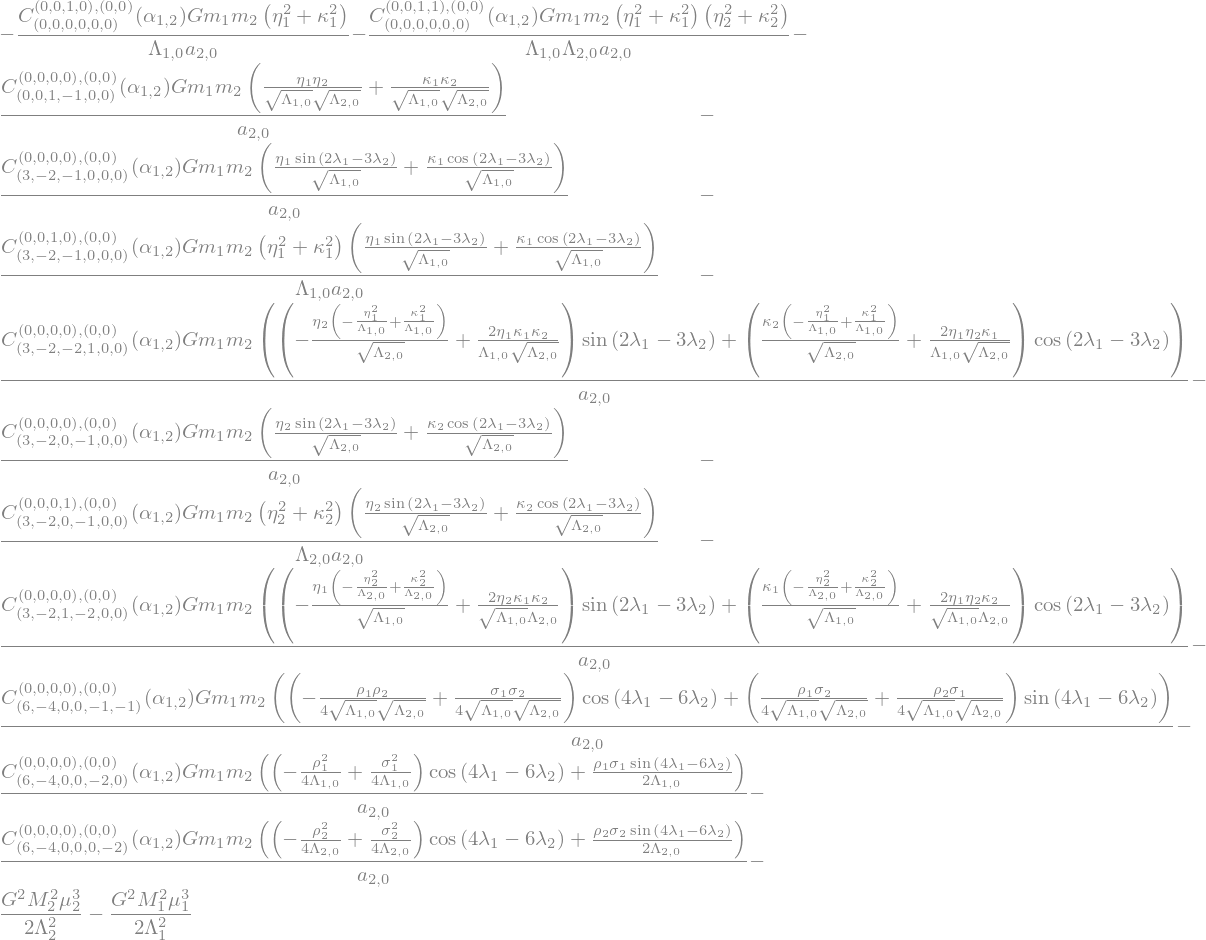

In [3]:
pvars = Poincare.from_Simulation(sim)
pham = PoincareHamiltonian(pvars)
pham.add_eccentricity_MMR_terms(3,1,1,update=False)

# Secular terms
pham.add_monomial_term([0,0,0,0,0,0],[0,0,1,0],update=False)
pham.add_monomial_term([0,0,0,0,0,0],[0,0,1,1],update=False)
pham.add_monomial_term([0,0,1,-1,0,0],[0,0,0,0],update=False)

# e^3 3:2 terms (for fun)
pham.add_monomial_term([3,-2,-1,0,0,0],[0,0,1,0],update=False)
pham.add_monomial_term([3,-2,0,-1,0,0],[0,0,0,1],update=False)
pham.add_monomial_term([3,-2,1,-2,0,0],[0,0,0,0],update=False)
pham.add_monomial_term([3,-2,-2,1,0,0],[0,0,0,0],update=False)

# Inclination terms
pham.add_monomial_term([6,-4,0,0,-2,0],[0,0,0,0],update=False)
pham.add_monomial_term([6,-4,0,0,-1,-1],[0,0,0,0],update=False)
pham.add_monomial_term([6,-4,0,0,0,-2],[0,0,0,0])
pham.H

The Hamiltonian looks messy in part because, by default, celmech uses Cartesian elements for the eccentricities and inclinations. So one transformation that routinely comes up is to new angles that are linear combinations of the various Poincare angles. This transformation is always canonical.

## Transformation 1: To new linear combinations of the default Poincare angles

Create transfromation from poincare variables to new variables using
$$
\begin{pmatrix}
Q_1\\
\vdots\\
Q_{3N}
\end{pmatrix}
 = 
 A
 \cdot
\begin{pmatrix}
\lambda_1\\
\vdots\\
\lambda_N\\
\gamma_1\\
\vdots\\
\gamma_N\\
q_1\\
\vdots\\
q_N
\end{pmatrix} 
$$

We only have to specify the array $A$, where each row corresponds to the linear combinations for each new angle:

In [4]:
A = np.array([
    [-2,3,0,0,0,0],
    [1,-1,0,0,0,0],
    [-2,3,+1,0,0,0],
    [-2,3,0,+1,0,0],
    [-2,3,0,0,+1,0],
    [-2,3,0,0,0,+1]
])
new_angles_tr = CanonicalTransformation.from_poincare_angles_matrix(pvars,A)

We can check whether the transformation we put in matches up with what we desired by checking the rule it created for the new variables in terms of the old:

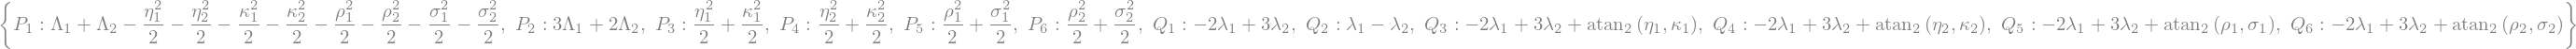

In [5]:
new_angles_tr.new_to_old_rule

We can see the that the new angles $Q_i$ follow the linear combinatinos specified by $A$, and the new actions $P_i$ are determined automatically from the requirement that the transformation be canonical. We can also use this transformation instance to transform our Hamiltonian to our new variables, which simplifies things considerably (most variables are constants if you check `new_ham.NH`)

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/sympy/matrices/matrices.py:3078: SymPyDeprecationWarning: 

Dot product of non row/column vectors has been deprecated since SymPy
1.2. Use * to take matrix products instead. See
https://github.com/sympy/sympy/issues/13815 for more info.

  useinstead="* to take matrix products").warn()


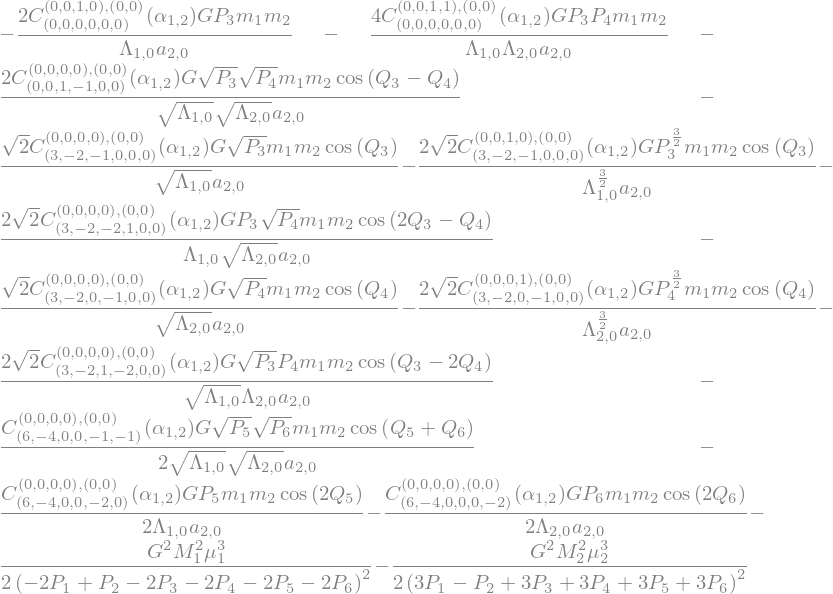

In [6]:
new_ham = new_angles_tr.old_to_new_hamiltonian(pham)
new_ham.H

## Transformation 2: polar to cartesian

Another transformation that comes up frequently is going back and forth between polar and cartesian variables. For the transformation to be canonical, this implies a relationship going from variables $(P_i,Q_i)$ to $(x_i,y_i) = \sqrt{2P_i}\times(\cos Q_i, \sin Q_i)$.

If we have a set of coordinates and momenta

In [7]:
new_ham.pqpairs

we can choose to only transform a subset of these $(P,Q)$ pairs by passing a list of indices that should be transformed (note that these indices start at 0, so $(P_1, Q_1)$ corresponds to index 0). To only convert the last 4 $(P,Q)$ pairs we do

In [8]:
to_cart_tr = CanonicalTransformation.PolarToCartesian(new_ham.pqpairs,indices=[2,3,4,5])

and can check the resulting transformation equations:

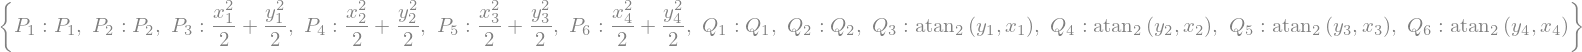

In [9]:
to_cart_tr.old_to_new_rule

The Hamiltonian in the new cartesian variables is

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/sympy/matrices/matrices.py:3078: SymPyDeprecationWarning: 

Dot product of non row/column vectors has been deprecated since SymPy
1.2. Use * to take matrix products instead. See
https://github.com/sympy/sympy/issues/13815 for more info.

  useinstead="* to take matrix products").warn()


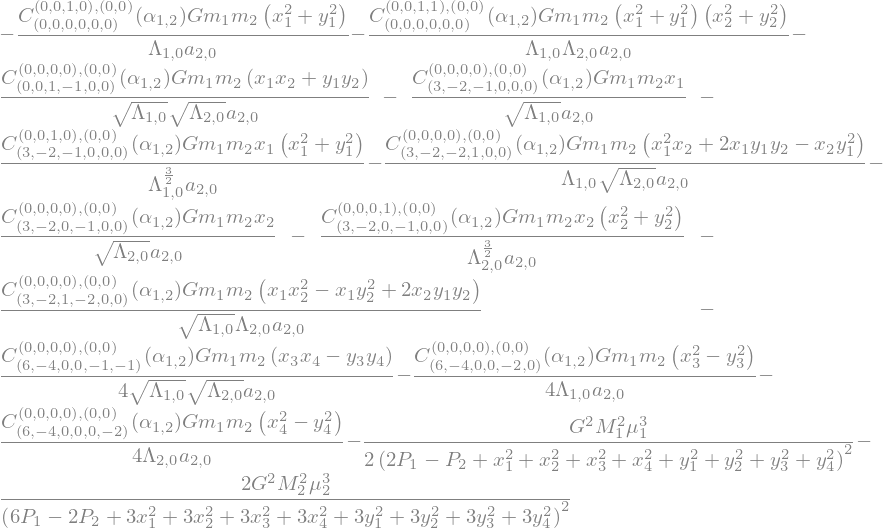

In [10]:
new_ham_cart = to_cart_tr.old_to_new_hamiltonian(new_ham)
new_ham_cart.H

## Composite Transformations

We often want to chain sequences of transformations. For example, to concatenate the above two transformations (note order matters, we want to do the angle transformation first):

In [11]:
trans = CanonicalTransformation.Composite([new_angles_tr, to_cart_tr])

We are also often interested in expressing our final variables all the way back in terms of the original ones, which we can do with

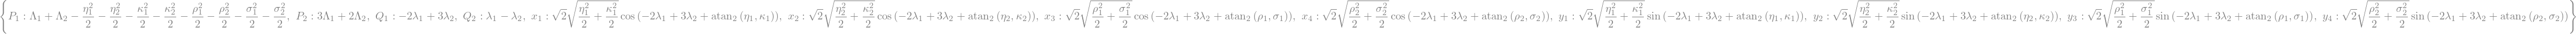

In [12]:
trans.new_to_old_rule

Unfortunately, if we use this new transformation to go from our original Hamiltonian instance `pham` to one in the new variables (in a single step) we get a mess. 

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/sympy/matrices/matrices.py:3078: SymPyDeprecationWarning: 

Dot product of non row/column vectors has been deprecated since SymPy
1.2. Use * to take matrix products instead. See
https://github.com/sympy/sympy/issues/13815 for more info.

  useinstead="* to take matrix products").warn()


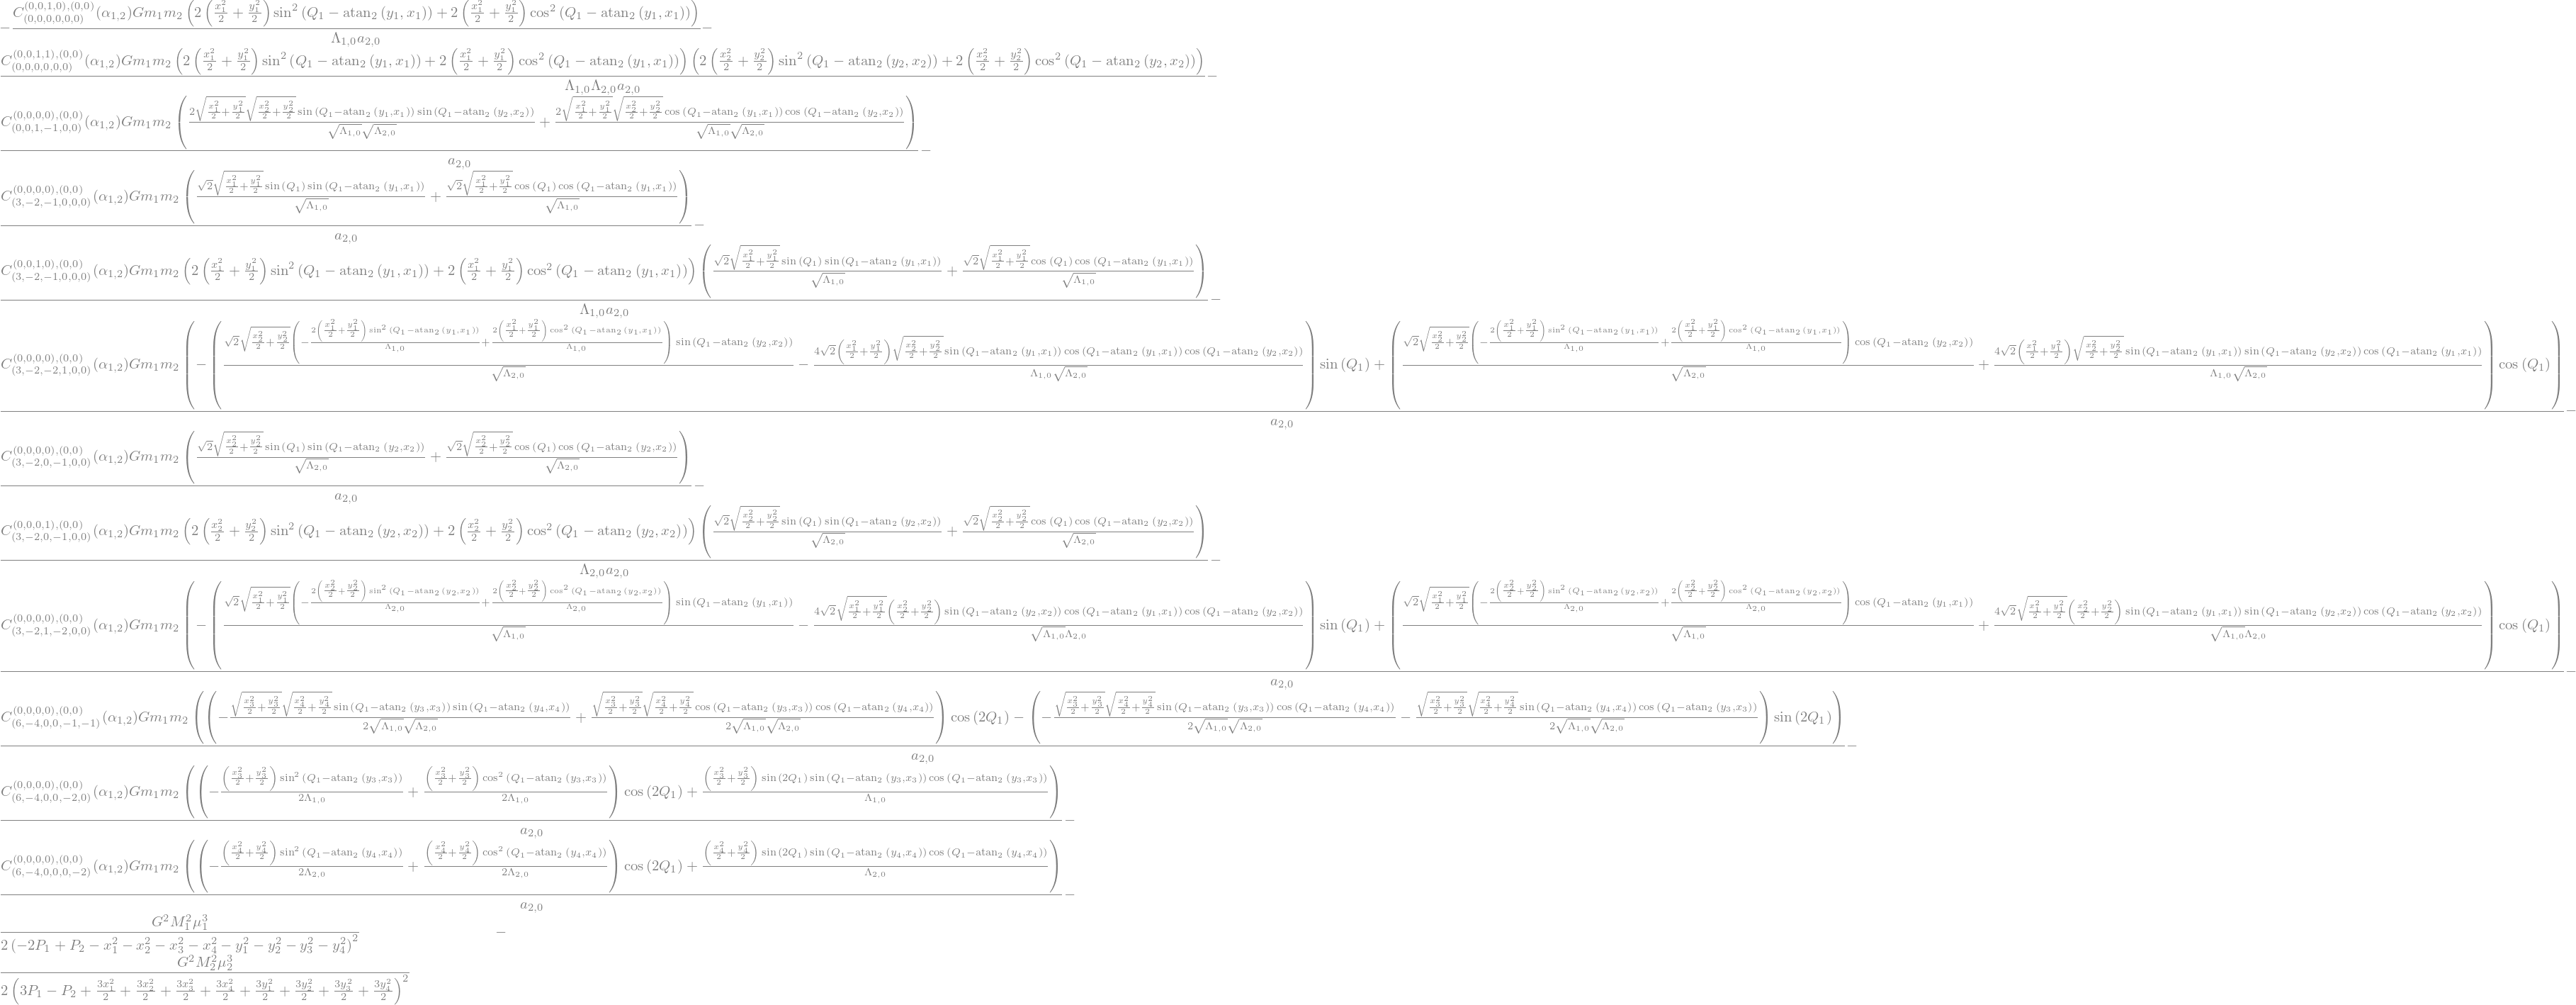

In [13]:
transham = trans.old_to_new_hamiltonian(pham)
transham.H

`sympy` will not always find all the appropriate simplifications, and while `celmech` can provide it with the appropriate hints behind the scenes for simple cases like the `PolarToCartesian` transformation above, it can't handle all general composite transfomrations. This is a place where you have to experiment manually. All `CanonicalTransformation` classes allow you to manually pass a function that takes a `sympy` expression and returns a simplified one. It can sometimes help `sympy` to simplify expressions term by term. You could do that with

`simpfunction = lambda x: x.func(*[do_what_you_want(term) for term in x.args])`

In our case we we can get `sympy` to simplify things by first applying a trigonometric simplification to each term: 

In [14]:
from sympy import simplify, trigsimp
o2n_simplify = lambda x: x.func(*[simplify(trigsimp(term)) for term in x.args])

Now if we create our transformation with this simplification function to be applied when transforming from old to new variables, if we transform our original Hamiltonian `pham`, we get back the simpler expression we obtained above:

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/sympy/matrices/matrices.py:3078: SymPyDeprecationWarning: 

Dot product of non row/column vectors has been deprecated since SymPy
1.2. Use * to take matrix products instead. See
https://github.com/sympy/sympy/issues/13815 for more info.

  useinstead="* to take matrix products").warn()


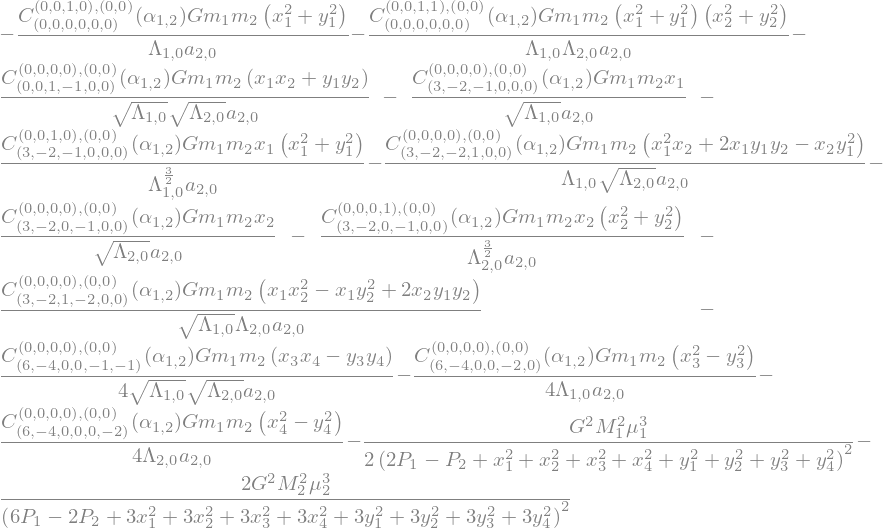

In [15]:
trans = CanonicalTransformation.Composite([new_angles_tr, to_cart_tr], old_to_new_simplify=o2n_simplify)
transham = trans.old_to_new_hamiltonian(pham)
transham.H

## Reducing the number of degrees of freedom

In [17]:
Nout = 1000
times = np.linspace(0, 1000, Nout)
L1, L2 = np.zeros(Nout), np.zeros(Nout)
P1, P2 = np.zeros(Nout), np.zeros(Nout)
for i, t in enumerate(times):
    pham.integrate(t)
    transham.integrate(t)
    L1[i] = pham.state.values[6]
    L2[i] = pham.state.values[9]
    P1[i] = transham.state.values[6]
    P2[i] = transham.state.values[9]

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1182: UserWarning: dop853: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))


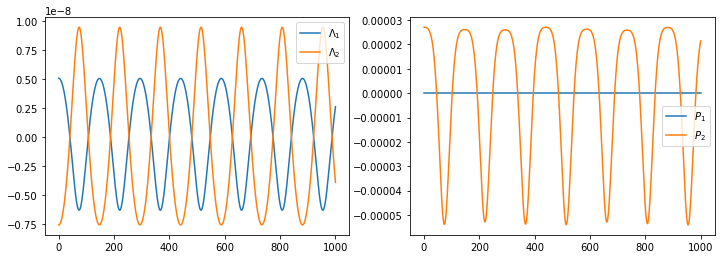

In [20]:
fig, axarr = plt.subplots(ncols=2, figsize=(12,4))
axarr[0].plot(times, L1-L1.mean(), label=r'$\Lambda_1$')
axarr[0].plot(times, L2-L2.mean(), label=r'$\Lambda_2$')
axarr[1].plot(times, P1-P1.mean(), label=r'$P_1$')
axarr[1].plot(times, P2-P2.mean(), label=r'$P_2$')
axarr[0].legend()
axarr[1].legend()

In [12]:
new_ham_cart = to_cart_tr.old_to_new_hamiltonian(new_ham,do_reduction=True)

In [13]:
print("The number of degrees of freedom has been reduced by {}".format(new_ham.state.Ndof - new_ham_cart.state.Ndof))

The number of degrees of freedom has been reduced by 2


In [14]:
new_ham_cart.H

-C_{(0,0,0,0,0,0)}^{(0,0,1,0),(0,0)}(\alpha_{1,2})*G*m1*m2*(x1**2 + y1**2)/(\Lambda_{1,0}*a_{2,0}) - C_{(0,0,0,0,0,0)}^{(0,0,1,1),(0,0)}(\alpha_{1,2})*G*m1*m2*(x1**2 + y1**2)*(x2**2 + y2**2)/(\Lambda_{1,0}*\Lambda_{2,0}*a_{2,0}) - C_{(0,0,1,-1,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{1,2})*G*m1*m2*(x1*x2 + y1*y2)/(sqrt(\Lambda_{1,0})*sqrt(\Lambda_{2,0})*a_{2,0}) - C_{(3,-2,-1,0,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{1,2})*G*m1*m2*x1/(sqrt(\Lambda_{1,0})*a_{2,0}) - C_{(3,-2,-1,0,0,0)}^{(0,0,1,0),(0,0)}(\alpha_{1,2})*G*m1*m2*x1*(x1**2 + y1**2)/(\Lambda_{1,0}**(3/2)*a_{2,0}) - C_{(3,-2,-2,1,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{1,2})*G*m1*m2*(x1**2*x2 + 2*x1*y1*y2 - x2*y1**2)/(\Lambda_{1,0}*sqrt(\Lambda_{2,0})*a_{2,0}) - C_{(3,-2,0,-1,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{1,2})*G*m1*m2*x2/(sqrt(\Lambda_{2,0})*a_{2,0}) - C_{(3,-2,0,-1,0,0)}^{(0,0,0,1),(0,0)}(\alpha_{1,2})*G*m1*m2*x2*(x2**2 + y2**2)/(\Lambda_{2,0}**(3/2)*a_{2,0}) - C_{(3,-2,1,-2,0,0)}^{(0,0,0,0),(0,0)}(\alpha_{1,2})*G*m1*m2*(x1*x2**2 - x1*y2**2 + 2*x2

# Let's use our new, transformed Hamiltonian to solve for equilibrium solutions.


In [15]:
# Get symbols
P1,P2 = sympy.symbols("P(1:3)")
Q1,Q2 = sympy.symbols("Q(1:3)")
xvec=sympy.symbols("x(1:5)")
yvec=sympy.symbols("y(1:5)")

We know that the equilibrium solutions should have zero inclination and zero $y$ components

In [16]:
# Set up rule
eqrule = dict(zip(yvec,np.zeros(4)))
eqrule.update(dict(zip(xvec[2:],np.zeros(2))))

# Below, we'll vary P1 and solve for different equilibria
pars = new_ham_cart.Hparams.copy()
P10 = pars.pop(P1)

In [17]:
# set up functions for root-finding
fn = new_ham_cart.flow.subs(eqrule).subs(pars)[:2]
Dfn = sympy.Matrix(2,2,lambda i,j: sympy.diff(fn[i],xvec[j]))

# Show expression for fn[0]
fn[0]

0.090170097839506*x1**2 - 391.94702957244*x1*x2**2 + 0.11960644045578*x1*x2 - 0.000331300194788536*x1 + 2.99991000269992e-15*x1/(P1 + x1**2/2 + x2**2/2 - 2.86646114393161e-5)**3 + 6.74979750607482e-15*x1/(P1 + x1**2/2 + x2**2/2 - 4.29969171589742e-5)**3 + 0.196110878526581*x2**2 + 0.00026864135326038*x2 + 1.17381712657768e-6

In [18]:
# Lambdify functions for root-finding
from scipy.optimize import root
fnN=sympy.lambdify([xvec[0],xvec[1],P1],fn)
DfnN=sympy.lambdify([xvec[0],xvec[1],P1],Dfn)

In [19]:
cart_state = new_ham_cart.state

# Array to store equilibria
Nout = 30
eq_dyvars_cart = np.zeros((Nout,len(to_cart_tr.new_qpvars_list)))
eq_dyvars_poincare = np.zeros((Nout,pvars.Ndim))

iQ1 = to_cart_tr.new_qpvars_list.index(Q1)
iQ2 = to_cart_tr.new_qpvars_list.index(Q2)

iP1 = to_cart_tr.new_qpvars_list.index(P1)
iP2 = to_cart_tr.new_qpvars_list.index(P2)

ix1 = to_cart_tr.new_qpvars_list.index(xvec[0])
ix2 = to_cart_tr.new_qpvars_list.index(xvec[1])



eq_dyvars_cart[:,iQ1] = float(Q1.subs(new_ham.state.as_rule()))
eq_dyvars_cart[:,iQ2] = float(Q2.subs(new_ham.state.as_rule()))
eq_dyvars_cart[:,iP2] = new_ham_cart.Hparams[P2]


# Note--
# P1 ~ (L10 + L20) - (L10*e1^2/2 + L20*e2^2/2)
########################################################
emax = 0.05

# I write this snippet a lot.
# Would probably be good to make a PoincareHamiltonian method that gives these values or something.
from celmech.poincare import _get_Lambda0_symbol
L10_val,L20_val = [pham.Hparams[_get_Lambda0_symbol(i)] for i in range(1,3)]
###################################

P1vals = P10 + np.linspace(1,-2,Nout) * (L10_val + L20_val) * emax**2
eq_dyvars_cart[:,iP1] = P1vals

guess = np.zeros(2)
for i,P1val in enumerate(P1vals):
    # Solve for equilibrium
    soln = root(lambda x: fnN(*x,P1val),guess,jac = lambda x: DfnN(*x,P1val))
    guess = soln.x
    x1eq,x2eq = guess
    eq_dyvars_cart[i,ix1] = x1eq
    eq_dyvars_cart[i,ix2] = x2eq 
    
    # Invert transformation
    polar_eq = to_cart_tr.new_to_old_array(eq_dyvars_cart[i])
    
    poincare_eq = new_angles_tr.new_to_old_array(polar_eq)
    
    eq_dyvars_poincare[i] = poincare_eq

 - Would be nice to be able make a "composite" transformation combining `to_cart_rt` and `new_angles_tr`
 
 
 - An annoyance that it would also be nice to address is that  `to_cart_tr.new_to_old_array` takes ``len(to_cart_tr.old_qpvars_list)=12`` arguments but, because we reduced the Hamiltonian generated using 
 ```python
    new_ham_cart = to_cart_tr.old_to_new_hamiltonian(new_ham,do_reduction=True)
```
the state object of the new Hamiltonian, `new_ham_cart.state`, represents an `new_ham_cart.state.Ndof=4` and `len(new_ham_cart.state.values) = 8`. 

It would be very nice to transform to a reduced Hamiltonian, do some calculations in the variables of the reduced Hamiltonian (e.g., solve for equilibria, do an integration, etc.), then transform the results back to the original variables (Poincare or otherwise). In this instance, we need to pass along the values of $(P_1,P_2,Q_1,Q_2)$ in order to do so. I'm not sure what the best way to do this is. Perhaps `celmech.hamiltonian.PhaseSpaceState` objects could cary around integrals of motion and cyclic coordinates? Or the canonical transformation can return some information about whether conserved quantities are found when `old_to_new_hamiltonian` is called (e.g., as a dictionary) and this info can later be passed as an optional argument to `to_cart_tr.new_to_old_array`. 

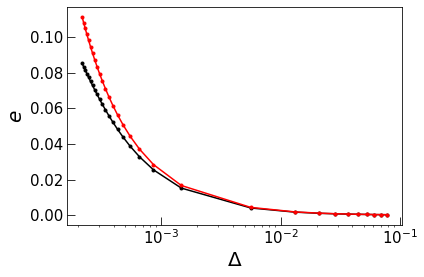

In [24]:
e1,e2,Delta = np.zeros((3,Nout))
for i,eq in enumerate(eq_dyvars_poincare):
    pvars.values = eq
    e1[i] = pvars.particles[1].e
    e2[i] = pvars.particles[2].e
    
    per1 = pvars.particles[1].P
    per2 = pvars.particles[2].P
    
    Delta[i] = 2 * per2 / per1 / 3 - 1

plt.plot(Delta,e1,'k.-')
plt.plot(Delta,e2,'r.-')
plt.xlabel("$\Delta$",fontsize=20)
plt.ylabel("$e$",fontsize=20)
plt.xscale('log')
plt.tick_params(labelsize=15,direction='in',size=8)

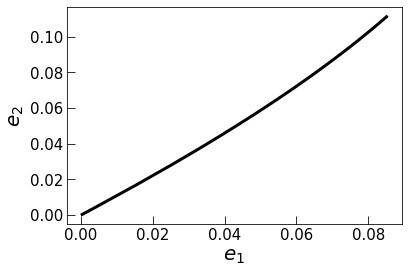

In [26]:
plt.plot(e1,e2,'k-',lw=3)
plt.xlabel("$e_1$",fontsize=20)
plt.ylabel("$e_2$",fontsize=20)
plt.tick_params(labelsize=15,direction='in',size=8)